In [1]:
import glob
import sahi

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from sklearn.metrics import auc

In [2]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

## Auxiliary functions

In [3]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [4]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [6]:
predictions = get_prediction(read_image("people_frames/people_frames_10.jpg"), detection_model)

In [7]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [8]:
image = cv2.imread("people_frames/people_frames_10.jpg")
height, width = image.shape[:2]

In [9]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [10]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [11]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

### Unite all in one function

In [12]:
def compute_AP50(gt_path, predictions, image_path):
    '''
    compute AP50 for one image
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=='0'] #select only people (class 0)
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(1000))
    i=0
    for result in predictions:
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = image_path
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            ious=[]
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0
            i+=1
        else:
            continue

    num_gt = len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt


    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



### Get usual predictions

In [13]:
predictions = get_prediction(read_image("people_frames/people_frames_2.jpg"), detection_model)
#results in form tlwh
results = predictions.to_coco_annotations()

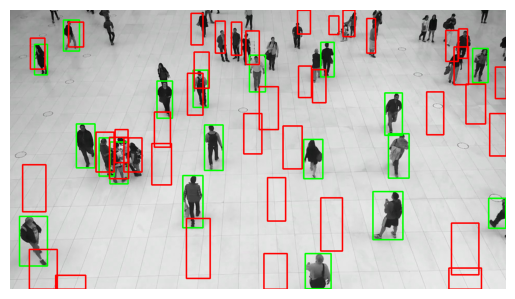

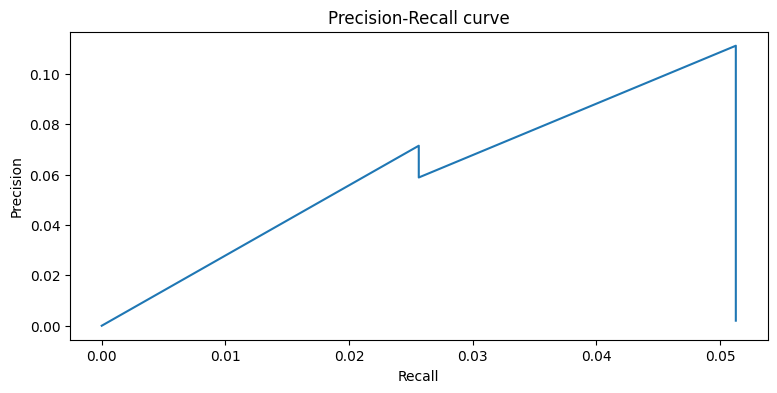

AP50 = 0.0031


In [14]:
compute_AP50("datasets/labels/people_frames_2.txt", results, "people_frames/people_frames_2.jpg")

## Get sliced predictions

In [109]:
result = get_sliced_prediction(
    "people_frames/people_frames_1.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.8,
    overlap_width_ratio = 0.8
)

Performing prediction on 12 number of slices.


In [110]:
results = result.to_coco_annotations()

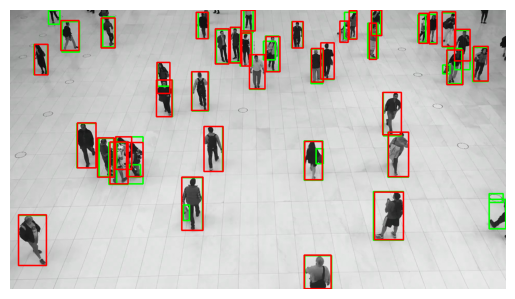

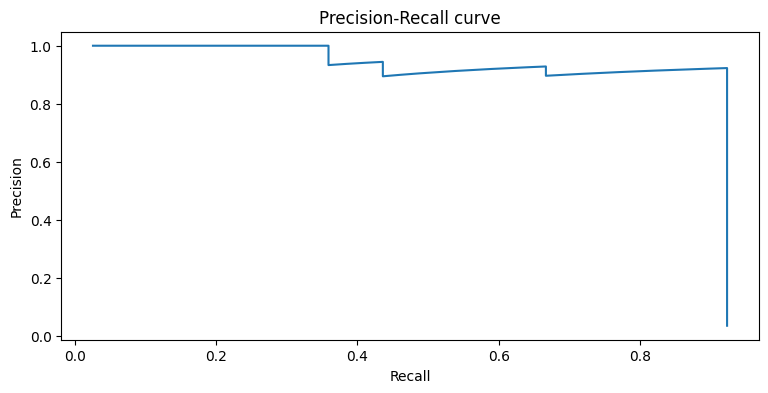

AP50 = 0.8501


In [111]:
compute_AP50("datasets/labels/people_frames_1.txt", results, "people_frames/people_frames_1.jpg")

In [32]:
def make_prediction(image_dir, destination_dir):

    for image in glob.glob(f"{image_dir}/*.jpg"):

        predictions = get_sliced_prediction(
        image,
        detection_model,
        slice_height = 512,
        slice_width = 512,
        overlap_height_ratio = 0.2,
        overlap_width_ratio = 0.2
        )

        file_name = image.split("/")[-1].split(".")[0]

        results = predictions.to_coco_annotations()

        with open(f"{destination_dir}/{file_name}.txt", "w+") as f:
            for result in results:
                f.write(str(result['category_id'])+" ")
                f.write(" {:.8f}".format(result['score']))
                for box in result['bbox']:
                    f.write(" {:.8f}".format(box))
                f.write("\n")


In [34]:
make_prediction("datasets/images", "sliced_results")

Performing prediction on 6 number of slices.


FileNotFoundError: [Errno 2] No such file or directory: 'sliced_results/images\\0b2d2a75ba981837.txt'

In [40]:
def compute_AP50_all(gt_dir, predictions_dir, image_dir):
    '''
    compute AP50 for batch of images
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(10000))

    num_gt=0
    i=0


    for image_path in glob.glob(f"{image_dir}/*.jpg"):

        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        file_name = image_path.split("/")[-1].split(".")[0]

        gt_path = f"{gt_dir}/{file_name}.txt"

        with open(gt_path, "r") as f:
            boxes= f.readlines()

        #gt boxes are in the format x_c, y_c, width, height
        gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
        gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
        gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
        gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

        print(gt_boxes)
        num_gt += len(gt_boxes)


        predictions_path = f"{predictions_dir}/{file_name}.txt"

        with open(predictions_path, "r") as f:
            predictions = f.readlines()


        for result in predictions:
            prediction = result.split(" ")
            category_id = prediction[0]

            if category_id=='0': #only person
                predicted_boxes.loc[i]['image'] = file_name
                predicted_boxes.loc[i]['confidence']=float(prediction[2])
                pr_box=list(map(lambda x: float(x.strip()), prediction[3:]))
                pr_box=tlwh_tlbr(pr_box)
                #print(pr_box)
                ious=[]
                for gt_box in gt_boxes:
                    iou = intersection_over_union(gt_box, pr_box)
                    ious.append(iou)
                if max(ious)>0.5:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['TP']=1
                    predicted_boxes.loc[i]['FP']=0

                else:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['FP']=1
                    predicted_boxes.loc[i]['TP']=0
                i+=1

            else:
                continue



    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False, inplace=True)


    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt



    #plot predictions
        # for result in predictions:
        #     pr_box=result['bbox'].copy()
        #     pr_box=tlwh_tlbr(pr_box)
        #     cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

        # #plot ground truth
        # for box in gt_boxes:
        #     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
        # plt.imshow(image)
        # plt.axis('off')
        # plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    print(predicted_boxes)

    # ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    # print(f"AP50 = {ap50 :.4f}")



    return predicted_boxes


[[857.00016, 65.99988, 888.99984, 136.00008], [163.74, 237.59000999999998, 203.84976, 316.79018999999994], [189.45023999999998, 244.7901, 229.57056, 328.10022], [220.3104, 246.84993, 254.25023999999996, 315.75987], [485.68031999999994, 139.87026, 523.7404799999999, 220.10021999999998], [584.9995200000001, 120.00015, 611.99952, 180.00009], [282.0, 193.00005, 313.00032, 254.00007], [42.00048, 54.999810000000004, 68.00016000000001, 115.99983000000002], [200.77056000000002, 230.38965, 230.59008000000003, 300.32991], [525.9998400000001, 234.00008999999997, 566.00016, 319.99994999999996], [553.00032, 105.00003000000001, 582.0, 167.00013], [362.00016, 85.00005, 389.00016000000005, 149.00031], [346.00032, 126.99963000000001, 375.0, 203.99984999999998], [808.00032, 167.00013, 845.0006399999999, 251.99991], [882.00048, 137.9997, 920.00016, 220.99985999999998], [45.0, 450.00009, 100.00032000000002, 540.00027], [846.99984, 395.00001000000003, 897.99984, 487.89999], [500.00015999999994, 336.0001499

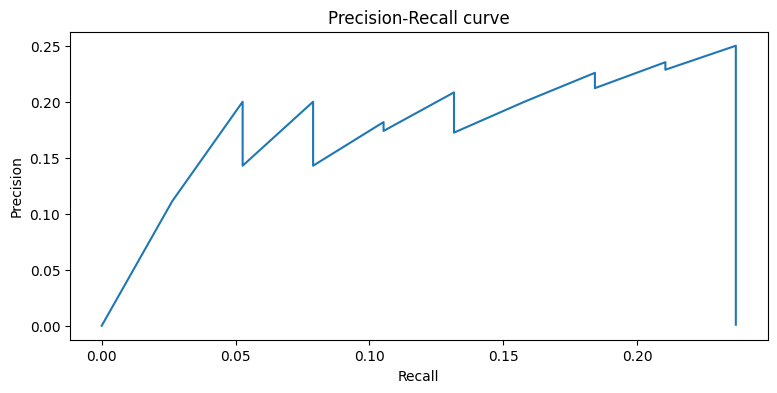

                 image confidence       iou   TP   FP Precision    Recall
0     people_frames_10   0.908436       0.0    0    1       0.0       0.0
1     people_frames_10   0.896845  0.161405    0    1       0.0       0.0
2     people_frames_10   0.890169   0.09122    0    1       0.0       0.0
3     people_frames_10   0.885712       0.0    0    1       0.0       0.0
4     people_frames_10   0.874555       0.0    0    1       0.0       0.0
...                ...        ...       ...  ...  ...       ...       ...
9995               NaN        NaN       NaN  NaN  NaN    0.0009  0.236842
9996               NaN        NaN       NaN  NaN  NaN    0.0009  0.236842
9997               NaN        NaN       NaN  NaN  NaN    0.0009  0.236842
9998               NaN        NaN       NaN  NaN  NaN    0.0009  0.236842
9999               NaN        NaN       NaN  NaN  NaN    0.0009  0.236842

[10000 rows x 7 columns]


In [41]:
data = compute_AP50_all("test_dataset/labels", "sliced_results", "test_dataset/images")

In [39]:
data

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_1,0.920242,0.958741,1,0,1.0,0.012987
1,people_frames_1,0.912057,0.973285,1,0,1.0,0.025974
37,people_frames_10,0.908436,0.0,0,1,0.552632,0.272727
38,people_frames_10,0.896845,0.161405,0,1,0.538462,0.272727
39,people_frames_10,0.890169,0.09122,0,1,0.55,0.285714
...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,0.004402,0.571429
9996,NaN,NaN,NaN,NaN,NaN,0.004401,0.571429
9997,NaN,NaN,NaN,NaN,NaN,0.004401,0.571429
9998,NaN,NaN,NaN,NaN,NaN,0.0044,0.571429


In [38]:
data=data.dropna()

In [39]:
data

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_88,0.914794,0.0,0,1,0.0,0.0
1,people_frames_88,0.901582,0.384478,0,1,0.0,0.0
2,people_frames_88,0.901301,0.0,0,1,0.0,0.0
3,people_frames_88,0.898999,0.0,0,1,0.0,0.0
4,people_frames_88,0.88797,0.107097,0,1,0.0,0.0
...,...,...,...,...,...,...,...
4335,people_frames_62,0.481531,0.006675,0,1,0.201338,0.229676
4336,people_frames_62,0.478903,0.0,0,1,0.201291,0.229676
4337,people_frames_62,0.442171,0.0,0,1,0.201245,0.229676
4338,people_frames_62,0.435113,0.0,0,1,0.201198,0.229676


In [15]:
def show_annotations(image_dir, annotations_dir):
    image = cv2.imread(image_dir)

    height, width = image.shape[:2]


    with open(annotations_dir, "r") as f:
        boxes = f.readlines()

    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()




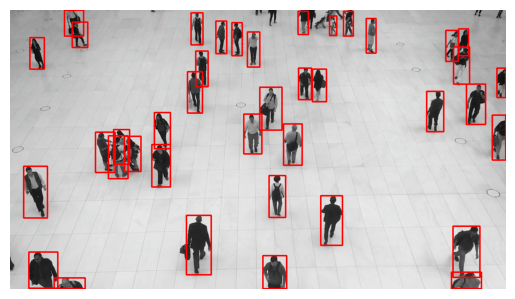

In [36]:
show_annotations("datasets/images/people_frames_113.jpg", "datasets/labels/people_frames_113.txt")

In [22]:
with open("people/obj_train_data/people_frames_2.txt", "r") as f:
    pass

FileNotFoundError: [Errno 2] No such file or directory: 'people/obj_train_data/people_frames_2.txt'

In [102]:
import os
files = os.listdir("people/obj_train_data")

for file_name in files:
    with open(f"people/obj_train_data/{file_name}", "r") as f:
        lines = f.readlines()
        if len(lines)>0: #if there is annotation for this file - copy it and annotations to the datasets dir
            print(file_name)

FileNotFoundError: [Errno 2] No such file or directory: 'people/obj_train_data'